In [1]:
import numpy as np
import numpy.random as nrand
import pandas as pd
from bot import *
from datetime import timedelta

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pypfopt.efficient_frontier import EfficientFrontier, EfficientSemivariance
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from matplotlib.ticker import FuncFormatter
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [4]:
bot = CryptoBot()
print(bot.API_BASE_URL, bot.API_KEY, bot.SECRET_KEY)

orderList = bot.getOrderHistory()
accountSummary = bot.getAccountSummary()

print(orderList)
print(len(accountSummary))


https://api.crypto.com/v2/ PoftB2fvwcLWDFXzbzdp9B w2oASVq11MNJe2p7VasM2x
[]
57


In [5]:
print([x["currency"] for x in accountSummary])

['NEAR', 'FLOW', 'COMP', 'STX', 'BCH', 'DOT', 'OMG', 'BAND', 'BTC', 'KNC', 'ALGO', 'ATOM', 'WBTC', 'ONT', 'SNX', 'MANA', 'DAI', 'ETC', 'MKR', 'CELR', 'ETH', 'MCO', 'NEO', 'REN', 'LRC', 'ADA', 'ICX', 'VET', 'PAXG', 'BNT', 'DOGE', 'USDT', 'XRP', 'SAND', 'UMA', 'LTC', 'EGLD', 'USDC', 'ENJ', 'CRO', 'CRV', 'GRT', 'UNI', 'AAVE', 'WAVE', 'XLM', 'LINK', 'YFI', 'QTUM', 'XTZ', 'KSM', 'EOS', 'FIL', 'BAL', 'SKL', 'BAT', 'ZIL']


In [6]:
assets = ['ETH_USDT', 'EGLD_USDT', 'CRO_USDT', 'GRT_USDT', 'DOT_USDT']

In [7]:
def closeToSeries(candleSticks, assetName):
    df = pd.DataFrame(candleSticks)
    df['t'] = pd.to_datetime(df['t'],unit='ms')
    df = df.set_index('t')
    return df['c'].rename(assetName)

In [8]:
def getCoinData(assets, period):
    L = []
    for asset in assets:
        candleSticks = bot.getCandlesticks(asset, period)
        L.append(closeToSeries(candleSticks, asset))
    return pd.DataFrame(L).T

In [9]:
DATA = getCoinData(assets, '12h')

<AxesSubplot:xlabel='t'>

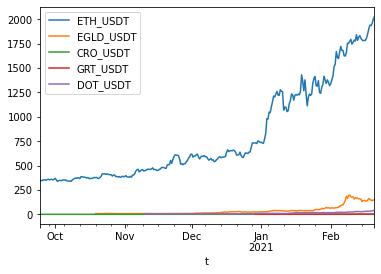

In [10]:
DATA.plot()

# PORTFOLIO OPTIMIZATION

In [11]:
def getWeights(optimizationType, returnData, priceData, lookBackLength, period):

    if (optimizationType == 'ew'):
        weights = np.ones(priceData.shape[1])/priceData.shape[1]
        return weights, None

    if (optimizationType == 'msv'):

        window = priceData[period - timedelta(hours=lookBackLength*12): period - timedelta(hours=12)]

        mu = expected_returns.mean_historical_return(window)
        Sigma = risk_models.sample_cov(window)

        ef = EfficientSemivariance(mu, Sigma, weight_bounds=(0,1))

        optimal_portfolio=ef.min_semivariance(market_neutral=False)
        ef_weights=ef.clean_weights()
        weights = np.array([v for (k, v) in ef_weights.items()])
        return weights, ef_weights

In [12]:
def getPortfolioReturn(returnData, priceData, lookbackLength, optimizationType, verbose=0):

    # initialize returns to empty series without lookback for first optimized weights
    portfolioReturns = pd.Series(np.zeros(len(priceData.index[lookbackLength:])), index=priceData.index[lookbackLength:])

    # initialize rebalance date as first date after end of lookback period as well as initial weights with window
    # ending at that date
    lastRebalanceDate = priceData.index[lookbackLength]
    weights, displayWeights = getWeights(optimizationType, returnData, priceData, lookbackLength, lastRebalanceDate)

    # initialize list of weights and dates for each rebalancing
    weightsList = []
    weightsRebalDates = []

    for t in priceData.index[lookbackLength:]:

        # perform weekly update of weights
        if (t - lastRebalanceDate == timedelta(days=7)):
            lastRebalanceDate = t
            weights, displayWeights = getWeights(optimizationType, returnData, priceData, lookbackLength, lastRebalanceDate)

            # assign latest weights and rebalance date to list
            weightsList.append(displayWeights)
            weightsRebalDates.append(lastRebalanceDate)

            if (verbose):
                print('rebalancing at date', lastRebalanceDate)
                print('new weights', displayWeights, '\n')

        assetReturns = returnData.loc[t].values
        portfolioReturn = weights @ assetReturns
        portfolioReturns[t] = portfolioReturn

    displayWeightsFrame = pd.DataFrame(weightsList, index=weightsRebalDates)
    
    return portfolioReturns, displayWeightsFrame

In [13]:
LOOKBACK_LENGTH = 20 # 10 days at 12h frequency
PRICE_DATA = DATA.dropna()
RET_DATA = DATA.dropna()[LOOKBACK_LENGTH:].pct_change().fillna(0)

In [15]:
rets_ew, _ = getPortfolioReturn(RET_DATA, PRICE_DATA, LOOKBACK_LENGTH, 'ew')
cumret_ew = np.cumprod(1+rets_ew)

In [16]:
rets_msv, weights_msv = getPortfolioReturn(RET_DATA, PRICE_DATA, LOOKBACK_LENGTH, 'msv', verbose=0)
cumret_msv = np.cumprod(1+rets_msv)

In [24]:
rets_eth = PRICE_DATA[LOOKBACK_LENGTH:].pct_change().fillna(0)["ETH_USDT"]
eth_cum = np.cumprod(1+rets_eth)

In [25]:
#PRICE_DATA["ETH_USDT"][LOOKBACK_LENGTH:]/PRICE_DATA["ETH_USDT"][LOOKBACK_LENGTH]

In [26]:
joined = pd.concat([rets_ew, rets_msv, rets_eth], axis=1)
joined.columns=['ew', 'msv', 'eth']

joined.describe().loc['mean']/joined.describe().loc['std']

ew     0.350518
msv    0.377837
eth    0.146102
dtype: float64

<AxesSubplot:xlabel='t'>

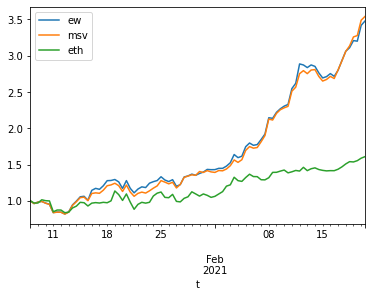

In [27]:
joined_cum = pd.concat([cumret_ew, cumret_msv, eth_cum], axis=1)
joined_cum.columns=['ew', 'msv', 'eth']
joined_cum.plot()

## ALLOCATION

In [28]:
weights_msv

,ETH_USDT,EGLD_USDT,CRO_USDT,GRT_USDT,DOT_USDT
2021-01-15,0.25285,0.29354,0.21330,0.15470,0.08561
2021-01-22,0.23470,0.34304,0.23764,0.09929,0.08532
2021-01-29,0.16733,0.33364,0.29110,0.12916,0.07877
2021-02-05,0.20034,0.22996,0.22431,0.18952,0.15586
2021-02-12,0.28792,0.12025,0.28350,0.10023,0.20809
2021-02-19,0.27939,0.19808,0.20442,0.05724,0.26087
